Fuente: https://cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python

In [ ]:
%%capture
#
!pip install pmdarima
!pip install skforecast

#Librerías

In [ ]:
# Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
import statsmodels.api as sm

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import missingno as msno

import warnings

In [ ]:
import statsmodels.api as sm

#Introducción

ARIMA (AutoRegressive Integrated Moving Average) y SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) son modelos estadísticos ampliamente reconocidos y utilizados para la predicción de series temporales (forecasting). Este modelo consta de tres componentes. El elemento autorregresivo (AR) relaciona el valor actual con valores pasados (lags). El elemento de media móvil (MA) asume que el error de predicción es una combinación lineal de los errores de predicción pasados. Por último, el componente integrado (I) indica que los valores de la serie original han sido reemplazados por la diferencia entre valores consecutivos (y este proceso de diferencia puede haberse realizado más de una vez).

Si bien los modelos ARIMA son ampliamente conocidos, los modelos SARIMAX extienden el marco de ARIMA al incorporar patrones estacionales y variables exógenas.

En la notación del modelo ARIMA-SARIMAX, los parámetros  p
 ,  d
 , y  q
  representan las componentes autorregresivas, de diferenciación y de media móvil, respectivamente.  P
 ,  D
 , y  Q
  son las mismas componentes para la parte estacional del modelo y  m
  el número de períodos en cada temporada.

p
  es el orden (número de lags temporales) de la parte autorregresiva del modelo.

d
  es el grado de diferenciación (el número de veces que se han restado los valores consecutivos de la serie).

q
  es el tamaño de la media móvil del modelo.

P
  es el orden (número de lags temporales) de la parte estacional del modelo.

D
  es el grado de diferenciación de la parte estacional del modelo.

Q
  es el tamaño de la media móvil de la parte estacional del modelo.

m
  indica al número de períodos en cada temporada.

Cuando los términos  P
 ,  D
 ,  Q
 , y  m
  son cero y no se incluyen variables exógenas, el modelo SARIMAX es equivalente a un ARIMA.

Varias librerías de Python implementan modelos ARIMA-SARIMAX. Cuatro de ellas son:

statsmodels: es una de las librerías más completas para modelado estadístico en Python. Su API suele resultar más intuitiva para aquellos que provienen del entorno R que para aquellos acostumbrados a la API orientada a objetos de scikit-learn.

pmdarima: esta librería adapta el modelo SARIMAX de statsmodels a la API de scikit-learn, lo que permite a los usuarios familiarizados con las convenciones de scikit-learn sumergirse fácilmente en el modelado de series temporales.

skforecast: entre sus múltiples funcionalidades de forecasting, dispone de una nueva adaptación para statsmodels SARIMAX que también sigue la API de scikit-learn. Esta implementación es muy similar a la de pmdarima, pero se ha simplificado para incluir solo los elementos esenciales para skforecast, lo que resulta en mejoras significativas de velocidad.

statsForecast: ofrece una colección de modelos de pronóstico de series temporales univariadas ampliamente utilizados, incluidos ARIMA automático, ETS, CES y modelado Theta optimizado para un alto rendimiento utilizando numba.

Este documento profundiza en tres de estas bibliotecas - statsmodels, pmdarima y skforecast - y explica cómo crear ARIMA-SARIMAX utilizando cada una. Además, muestra cómo de la clase ForecasterSarimax amplía las capacidades de los modelos ARIMA-SARIMAX al incorporar funcionalidades como la validación, ajuste de hiperparámetros, forecasting probabilísticos y más.

# Datos

##  Descarga datos

In [ ]:
url = 'https://raw.githubusercontent.com/MarianaDiazNobile/IPC/main/Base%20de%20datos_IPC_.csv'
# Leer el archivo CSV especificando el encoding
datos = pd.read_csv(url, encoding='ISO-8859-1', delimiter=';') #uso delimiter para especificar que el texto está separado con ;
datos.head(5)

,Fecha,"IPC Cba nivel general, base agos=100",IPC Cba Inflación Núcleo,"Base monetaria (M0), saldos a fin de mes en millones de pesos",M2,M2_moneda_nacional,M2_moneda_extranjera,M3,M3_moneda_nacional,M3_moneda_extranjera,M3_Total,M3_total_pesos,M3_total_moneda_extranjera,TCN,emae_des,emae_orig
0,2012-01,80.0,NaN,216117.0,367717.0,341019.0,26698.0,612704.0,554931.0,57774.0,614428.0,556600.0,57828.0,4.0,147.0,136.0
1,2012-02,81.0,NaN,205437.0,369498.0,343069.0,26429.0,620223.0,562759.0,57464.0,621792.0,564273.0,57519.0,4.0,145.0,132.0
2,2012-03,82.0,NaN,220626.0,370720.0,344530.0,26190.0,629669.0,572448.0,57221.0,631204.0,573927.0,57277.0,4.0,145.0,147.0
3,2012-04,83.0,NaN,222914.0,378584.0,351925.0,26660.0,640944.0,583177.0,57767.0,642545.0,584721.0,57824.0,4.0,142.0,146.0
4,2012-05,84.0,NaN,225512.0,389879.0,367364.0,22515.0,655401.0,603054.0,52348.0,656825.0,604421.0,52404.0,4.0,140.0,157.0


In [ ]:
datos = datos.rename(columns={'Fecha':'date', 'IPC Cba nivel general, base agos=100':'IPC_NG','IPC Cba Inflación Núcleo':'IPC_Nucleo',
                              'Base monetaria (M0), saldos a fin de mes en millones de pesos': 'M0', 'M2_moneda_nacional':'M2_pesos',
                              'M2_moneda_extranjera': 'M2_ME', 'M3_moneda_nacional':'M3_pesos',
                              'M3_moneda_extranjera': 'M3_ME','M3_total_moneda_extranjera': 'M3_Total_ME'})
display(datos.head(4))

,date,IPC_NG,IPC_Nucleo,M0,M2,M2_pesos,M2_ME,M3,M3_pesos,M3_ME,M3_Total,M3_total_pesos,M3_Total_ME,TCN,emae_des,emae_orig
0,2012-01,80.0,NaN,216117.0,367717.0,341019.0,26698.0,612704.0,554931.0,57774.0,614428.0,556600.0,57828.0,4.0,147.0,136.0
1,2012-02,81.0,NaN,205437.0,369498.0,343069.0,26429.0,620223.0,562759.0,57464.0,621792.0,564273.0,57519.0,4.0,145.0,132.0
2,2012-03,82.0,NaN,220626.0,370720.0,344530.0,26190.0,629669.0,572448.0,57221.0,631204.0,573927.0,57277.0,4.0,145.0,147.0
3,2012-04,83.0,NaN,222914.0,378584.0,351925.0,26660.0,640944.0,583177.0,57767.0,642545.0,584721.0,57824.0,4.0,142.0,146.0


In [ ]:
datos['date'] = pd.to_datetime(datos['date'], format='%Y-%m-%d')
datos = datos.set_index('date')
datos = datos.loc['2013-08-01 00:00:00':'2023-11-01 00:00:00']
datos = datos.asfreq('MS')
display(datos.head(4))

,IPC_NG,IPC_Nucleo,M0,M2,M2_pesos,M2_ME,M3,M3_pesos,M3_ME,M3_Total,M3_total_pesos,M3_Total_ME,TCN,emae_des,emae_orig
date,,,,,,,,,,,,,,,
2013-08-01,100.0,100.0,321192.0,544146.0,525617.0,18529.0,898528.0,853184.0,45344.0,900006.0,854642.0,45365.0,6.0,150.0,148.0
2013-09-01,101.0,101.0,327433.0,564597.0,544510.0,20087.0,923418.0,876071.0,47347.0,924669.0,877303.0,47367.0,6.0,150.0,147.0
2013-10-01,103.0,103.0,326803.0,560851.0,540311.0,20540.0,937694.0,889611.0,48083.0,938835.0,890732.0,48103.0,6.0,149.0,149.0
2013-11-01,105.0,106.0,336846.0,572556.0,550702.0,21854.0,955017.0,904815.0,50202.0,956164.0,905947.0,50218.0,6.0,148.0,146.0


## Train - Test - Fecha

In [ ]:
datos.describe()

,IPC_NG,IPC_Nucleo,M0,M2,M2_pesos,M2_ME,M3,M3_pesos,M3_ME,M3_Total,M3_total_pesos,M3_Total_ME,TCN,emae_des,emae_orig
count,124.000000,124.000000,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,1.240000e+02,124.000000,124.000000,124.000000
mean,929.798387,885.008065,1.913642e+06,5.138225e+06,4.186298e+06,9.519270e+05,8.660049e+06,7.373546e+06,1.286504e+06,8.706844e+06,7.416018e+06,1.290826e+06,65.927419,144.838710,144.701613
std,1218.577746,1184.104591,1.801073e+06,6.203887e+06,5.162992e+06,1.063726e+06,1.080409e+07,9.462043e+06,1.375447e+06,1.085930e+07,9.512337e+06,1.380262e+06,78.956319,6.873286,9.560233
min,100.000000,100.000000,3.211920e+05,5.441460e+05,5.256170e+05,1.852900e+04,8.985280e+05,8.531840e+05,4.534400e+04,9.000060e+05,8.546420e+05,4.536500e+04,6.000000,106.000000,113.000000
25%,201.500000,196.000000,5.753718e+05,1.088188e+06,9.940400e+05,1.072088e+05,1.776266e+06,1.588908e+06,2.019515e+05,1.778154e+06,1.590864e+06,2.020508e+05,14.000000,144.000000,138.000000
50%,420.500000,382.500000,1.223584e+06,2.669908e+06,1.830751e+06,8.614365e+05,4.359674e+06,3.178200e+06,1.194588e+06,4.383463e+06,3.198898e+06,1.199395e+06,37.000000,146.000000,146.000000
75%,1105.250000,1033.750000,2.490282e+06,6.338466e+06,5.067104e+06,1.271362e+06,1.068927e+07,8.937981e+06,1.752342e+06,1.075392e+07,8.996305e+06,1.757620e+06,94.250000,149.000000,150.000000
max,6471.000000,6365.000000,8.973530e+06,2.926760e+07,2.469369e+07,4.669615e+06,4.803651e+07,4.219039e+07,5.979399e+06,4.829652e+07,4.243388e+07,6.002194e+06,361.000000,153.000000,169.000000


In [ ]:
len_datos=len(datos.IPC_Nucleo)
len_train=round(len_datos*0.6)
print('la longitud del conjunto de entrenamiento es:',len_train)
len_test=round(len_datos*0.2)
print('la longitud del conjunto de test es:',len_test)
len_val=len_datos - len_train - len_test
print('la longitud del conjunto de validación es:',len_val)

la longitud del conjunto de entrenamiento es: 74
la longitud del conjunto de test es: 25
la longitud del conjunto de validación es: 25


In [ ]:
fechas_train = pd.date_range(start=datos.index.min(), periods=len_train, freq='MS')
fechas_test = pd.date_range(start=fechas_train[-1] + pd.DateOffset(months=1), periods=25, freq='MS')
fechas_val=pd.date_range(start=fechas_test[-1] + pd.DateOffset(months=1), periods=25, freq='MS')

print(f"Fechas train : {fechas_train[0]} --- {fechas_train[-1]}  (n={len(datos.loc[:fechas_train[-1]])})")
print(f"Fechas test : {fechas_test[0]} --- {fechas_test[-1]}  (n={len(datos.loc[fechas_test[0]:fechas_test[-1]])})")
print(f"Fechas validación : {fechas_val[0]} --- {fechas_val[-1]}  (n={len(datos.loc[fechas_val[0]:fechas_val[-1]])})")

Fechas train : 2013-08-01 00:00:00 --- 2019-09-01 00:00:00  (n=74)
Fechas test : 2019-10-01 00:00:00 --- 2021-10-01 00:00:00  (n=25)
Fechas validación : 2021-11-01 00:00:00 --- 2023-11-01 00:00:00  (n=25)


In [ ]:
datos_train = datos.loc[:fechas_train[-1]]
datos_test  = datos.loc[fechas_test[0]:fechas_test[-1]]
datos_val =  datos.loc[fechas_val[0]:fechas_val[-1]]

## Gráfico

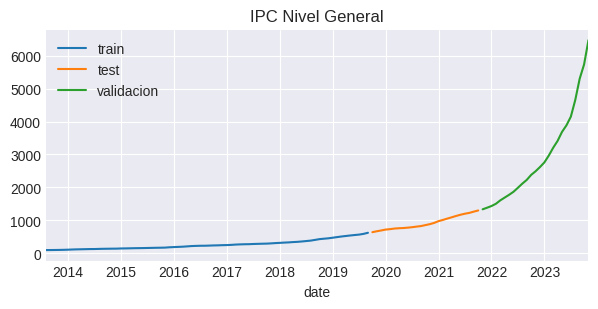

In [ ]:
fig, ax=plt.subplots(figsize=(7,3))
datos_train['IPC_NG'].plot(ax=ax,label='train')
datos_test ['IPC_NG'].plot(ax=ax, label='test')
datos_val['IPC_NG'].plot(ax=ax, label ='validacion')
ax.set_title('IPC Nivel General')
ax.legend();

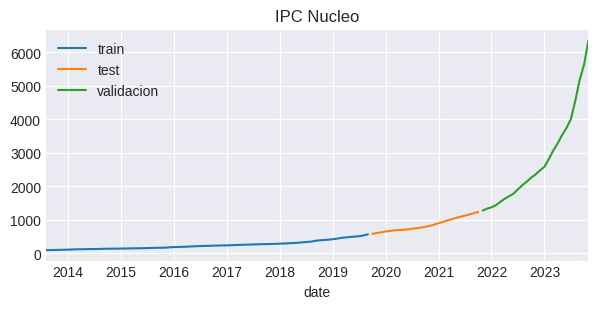

In [ ]:
fig, ax=plt.subplots(figsize=(7,3))
datos_train['IPC_Nucleo'].plot(ax=ax,label='train')
datos_test ['IPC_Nucleo'].plot(ax=ax, label='test')
datos_val['IPC_Nucleo'].plot(ax=ax, label ='validacion')
ax.set_title('IPC Nucleo')
ax.legend();

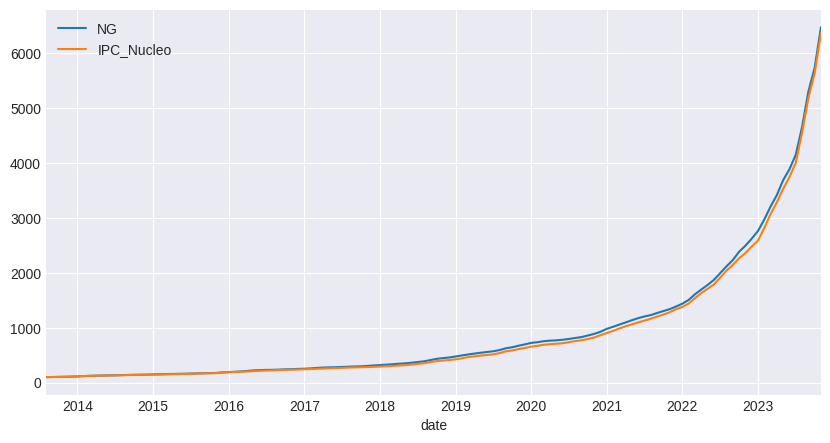

In [ ]:
datos['IPC_NG'].plot(figsize=(10,5), label='NG')
datos['IPC_Nucleo'].plot(label='IPC_Nucleo')
plt.legend(loc='upper left')
plt.show()

# Análisis Exploratorio

 Antes de entrenar un modelo ARIMA a una serie temporal, es importante realizar:

 1- **Estacionariedad**: la estacionariedad significa que las propiedades estadísticas (media, varianza...) permanecen constantes a lo largo del tiempo, por lo que las series temporales con tendencias o estacionalidad no son estacionarias. Dado que ARIMA presupone la estacionariedad de los datos, es esencial someterlos a pruebas rigurosas, como la prueba Dickey-Fuller aumentada, para evaluar que se cumple. Si se constata la no estacionariedad, las series deben diferenciarse hasta alcanzar la estacionariedad. Este análisis ayuda a determinar el valor óptimo del parámetro  d.


 2-**Análisis de autocorrelación**: Graficar las funciones de autocorrelación y autocorrelación parcial (ACF y PACF) para identificar posibles relaciones de rezago (lags) entre los valores de la serie. Este análisis visual ayuda a determinar los términos autorregresivos (AR) y de media móvil (MA) adecuados ( p   y  q  ) para el modelo ARIMA.


3- **Descomposición estacional**: en los casos donde se sospecha de estacionalidad, descomponer la serie en componentes de tendencia, estacionales y residuales utilizando técnicas como las medias móviles la descomposición estacional de series temporales (STL) puede revelar patrones ocultos y ayudar a identificar la estacionalidad. Este análisis ayuda a determinar los valores óptimos de los parámetros  P ,  D ,  Q  y  m .

## 1 - Estacionariedad

Existen varios métodos para evaluar si una serie temporal es estacionaria o no estacionaria:

**Inspección visual de la serie temporal**: inspeccionando visualmente el gráfico de la serie temporal, es posible identificar la presencia de una tendencia o estacionalidad notables. Si se observan estos patrones, es probable que la serie no sea estacionaria.

**Valores estadísticos:** calcular estadísticos como la media y la varianza, de varios segmentos de la serie. Si existen diferencias significativas, la serie no es estacionaria.

**Pruebas estadísticas:** utilizar test estadísticos como la prueba Dickey-Fuller aumentada o la prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS).

El gráfico generado en el apartado anterior muestra una clara tendencia positiva, lo que indica un aumento constante a lo largo del tiempo. En consecuencia, la media de la serie aumenta con el tiempo, lo que confirma su no estacionariedad.

La diferenciación es una de las técnicas más sencillas para eliminar la tendencia de una serie temporal. Consiste en generar una nueva serie en la que cada valor se calcula como la diferencia entre el valor actual y el valor anterior, es decir, la diferencia entre valores consecutivos

Esta es conocida como diferenciación de primer orden. Este proceso se puede repetir si es necesario hasta que se alcance la estacionariedad deseada.

 Normalmente, la cantidad correcta de diferenciación es el orden más bajo de diferenciación que produce una serie de tiempo que fluctúa alrededor de un valor medio bien definido y cuyo gráfico de función de autocorrelación (ACF) decae con bastante rapidez a cero.

### Prueba de Dickey-Fuller aumentada - adfuller()

Hipótesis nula ( HO): La serie tiene una raíz unitaria, no es estacionaria.

Hipótesis alternativa ( HA): La serie no tiene raíz unitaria, es estacionaria.

<font color='orange'> el p-value obtenido debe ser inferior a un nivel de significación determinado, a menudo fijado en 0.05, para rechazar esta hipótesis. Indicando que la serie temporal no tiene una raíz unitaria, lo que sugiere que podría ser estacionaria.

### Prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - kpss()

H0: la serie es estacionaria

HA: la serie es no estacionaria

La prueba KPSS comprueba si una serie temporal es estacionaria en torno a una media o una tendencia lineal. En esta prueba, la hipótesis nula es que la serie es estacionaria.

<font color='orange'> los p-values pequeños (por ejemplo, inferiores a 0.05) rechazan la hipótesis nula y sugieren que es necesario diferenciar. La prueba KPSS se centra en la presencia de tendencias. Un p-value bajo indica la no estacionariedad debida a una tendencia.

In [ ]:
warnings.filterwarnings("ignore")

datos_diff_1=datos_train.diff().dropna()
datos_diff_2=datos_diff_1.diff().dropna()
datos_diff_3=datos_diff_2.diff().dropna()

In [ ]:
print('Test estacionariedad IPC Nivel General serie original')
print('-----------------------------------------------------')
adfuller_result_NG=adfuller(datos.IPC_NG)
kpss_result_NG=kpss(datos.IPC_NG)

print(f'ADF Statistic:{adfuller_result_NG[0]}, p -value: {adfuller_result_NG[1]}')
print(f'KPSS Statistic:{kpss_result_NG[0]}, p-value: {kpss_result_NG[1]}')
print ('       ')
print ('       ')

print('Test estacionariedad IPC Núbleo serie original')
print('----------------------------------------------')
adfuller_result_Nucleo=adfuller(datos.IPC_Nucleo)
kpss_result_Nucleo=kpss(datos.IPC_Nucleo)

print(f'ADF Statistic:{ adfuller_result_Nucleo[0]}, p -value: { adfuller_result_Nucleo[1]}')
print(f'KPSS Statistic:{ kpss_result_Nucleo[0]}, p-value: { kpss_result_Nucleo[1]}')


Test estacionariedad IPC Nivel General serie original
-----------------------------------------------------
ADF Statistic:-4.5119551890238565, p -value: 0.00018708696557786817
KPSS Statistic:1.301379596757788, p-value: 0.01
       
       
Test estacionariedad IPC Núbleo serie original
----------------------------------------------
ADF Statistic:-4.470341055604496, p -value: 0.00022238255171350556
KPSS Statistic:1.2796142029784114, p-value: 0.01


En ADF el p-valor es de 0.00< 0.05, es decir se rechaza la hipótesis nula, es probable que la serie sea ESTACIONARIA.

En KPSS el p-valor es 0.01<0.05 se rechaza la hipótesis nula, es decir, la serie es NO ESTACIONARIA

#### Diferenciación de la serie

In [ ]:
## Diferenciación de orden 1

print('\nTest estacionariedad para serie IPC_NG  diferenciada (order=1)')
print('----------------------------------------------------------------')
adfuller_result_dif1_NG = adfuller(datos_diff_1.IPC_NG)
kpss_result_dif1_NG = kpss(datos_diff_1['IPC_NG'].dropna())
print(f'ADF Statistic: {adfuller_result_dif1_NG[0]}, p-value: {adfuller_result_dif1_NG[1]}')
print(f'KPSS Statistic: {kpss_result_dif1_NG[0]}, p-value: {kpss_result_dif1_NG[1]}')
print ('       ')
print ('       ')


print('\nTest estacionariedad para serie IPC_Nucleo  diferenciada (order=1)')
print('--------------------------------------------------------------------')
adfuller_result_dif1_Nucleo = adfuller(datos_diff_1.IPC_Nucleo)
kpss_result_dif1_Nucleo = kpss(datos_diff_1['IPC_Nucleo'].dropna())
print(f'ADF Statistic: {adfuller_result_dif1_Nucleo[0]}, p-value: {adfuller_result_dif1_Nucleo[1]}')
print(f'KPSS Statistic: {kpss_result_dif1_Nucleo[0]}, p-value: {kpss_result_dif1_Nucleo[1]}')


Test estacionariedad para serie IPC_NG  diferenciada (order=1)
----------------------------------------------------------------
ADF Statistic: 1.8802597838185353, p-value: 0.9984955901537592
KPSS Statistic: 1.1823894807943336, p-value: 0.01
       
       

Test estacionariedad para serie IPC_Nucleo  diferenciada (order=1)
--------------------------------------------------------------------
ADF Statistic: 1.9395580213903574, p-value: 0.9985890714726746
KPSS Statistic: 1.1205265758221905, p-value: 0.01


El ADF es 0,99 mayor al 0,05 es decir se acepta la hipótesis nula, la series ES NO ESTACIONARIA

Por otro lado el valor KPSS es 0,01 < 0,05 se rechaza la hipótesis nula, la serie es NO ESTACIONARIA

In [ ]:
## Diferenciación de orden 2

print('\nTest estacionariedad para serie IPC_NG diferenciada (order=2)')
print('--------------------------------------------------------')
adfuller_result_dif2_NG = adfuller(datos_diff_2.IPC_NG)
kpss_result_dif2_NG = kpss(datos_diff_2['IPC_NG'].dropna())
print(f'ADF Statistic: {adfuller_result_dif2_NG[0]}, p-value: {adfuller_result_dif2_NG[1]}')
print(f'KPSS Statistic: {kpss_result_dif2_NG[0]}, p-value: {kpss_result_dif2_NG[1]}')
print ('       ')
print ('       ')


print('\nTest estacionariedad para serie IPC_Nucleo diferenciada (order=2)')
print('--------------------------------------------------------')
adfuller_result_dif2_Nucleo = adfuller(datos_diff_2.IPC_Nucleo)
kpss_result_dif2_Nucleo = kpss(datos_diff_2['IPC_Nucleo'].dropna())
print(f'ADF Statistic: {adfuller_result_dif2_Nucleo[0]}, p-value: {adfuller_result_dif2_Nucleo[1]}')
print(f'KPSS Statistic: {kpss_result_dif2_Nucleo[0]}, p-value: {kpss_result_dif2_Nucleo[1]}')


Test estacionariedad para serie IPC_NG diferenciada (order=2)
--------------------------------------------------------
ADF Statistic: -5.696206572328104, p-value: 7.863561876528034e-07
KPSS Statistic: 0.32541940860017415, p-value: 0.1
       
       

Test estacionariedad para serie IPC_Nucleo diferenciada (order=2)
--------------------------------------------------------
ADF Statistic: -1.9672180053726465, p-value: 0.30112919072602007
KPSS Statistic: 0.3535085152129393, p-value: 0.09719460551166409


<font color='YELLOW'> **IPC_NIVEL GENERAL**

Prueba de Dickey-Fuller (ADF):

Valor p: 7.863561876528034e-07 (aproximadamente 0)
El valor p es muy pequeño (aproximadamente 0), lo que sugiere que podemos rechazar la hipótesis nula. Por lo tanto, hay evidencia suficiente para concluir que la serie diferenciada de segundo orden es **ESTACIONARIA**.

Prueba KPSS:

Valor p: 0.1
En este caso, el valor p es mayor que 0.05 (es 0.1), lo que sugiere que no hay suficiente evidencia para rechazar la hipótesis nula. Por lo tanto, la serie diferenciada de segundo orden parece ser **ESTACIONARIA** en términos de la prueba KPSS.

En resumen, según la prueba de Dickey-Fuller, la serie diferenciada de segundo orden es estacionaria, mientras que la prueba KPSS no proporciona evidencia suficiente para concluir lo contrario. Esto sugiere que la serie podría ser considerada estacionaria después de aplicar dos veces el operador de diferencia.

Una serie temporal se considera estacionaria cuando sus propiedades estadísticas, como la media, la varianza y la autocorrelación, permanecen constantes a lo largo del tiempo, lo que simplifica el análisis, modelado y la interpretación de los resultados.

<font color='YELLOW'> **IPC_NUCLEO**

Prueba de Dickey-Fuller (ADF):

Valor p: 0.30112919072602007
En este caso, el valor p es aproximadamente 0.301, que es mayor que 0.05. Por lo tanto, no hay suficiente evidencia para rechazar la hipótesis nula, lo que sugiere que la serie **NO ES ESTACIONARIA** según la prueba de Dickey-Fuller.

Prueba KPSS:

Valor p: 0.09719460551166409
En este caso, el valor p es aproximadamente 0.097, que es mayor que 0.05. Por lo tanto, no hay suficiente evidencia para rechazar la hipótesis nula, lo que sugiere que la serie **ES ESTACIONARIA** según la prueba KPSS.

Según las pruebas de Dickey-Fuller y KPSS, no hay suficiente evidencia para rechazar la hipótesis nula de que la serie IPC_Nucleo diferenciada de segundo orden es estacionaria. Sin embargo, es importante considerar otros factores y realizar un análisis más detallado para determinar la estacionariedad de la serie con mayor confianza.







In [ ]:
## Diferenciación de orden 3

print('\nTest estacionariedad para serie IPC_NG diferenciada (order=3)')
print('--------------------------------------------------------')
adfuller_result_dif3_NG = adfuller(datos_diff_3.IPC_NG)
kpss_result_dif3_NG = kpss(datos_diff_3['IPC_NG'].dropna())
print(f'ADF Statistic: {adfuller_result_dif3_NG[0]}, p-value: {adfuller_result_dif3_NG[1]}')
print(f'KPSS Statistic: {kpss_result_dif3_NG[0]}, p-value: {kpss_result_dif3_NG[1]}')
print ('       ')
print ('       ')


print('\nTest estacionariedad para serie IPC_Nucleo diferenciada (order=3)')
print('--------------------------------------------------------')
adfuller_result_dif3_Nucleo = adfuller(datos_diff_3.IPC_Nucleo)
kpss_result_dif3_Nucleo = kpss(datos_diff_3['IPC_Nucleo'].dropna())
print(f'ADF Statistic: {adfuller_result_dif3_Nucleo[0]}, p-value: {adfuller_result_dif3_Nucleo[1]}')
print(f'KPSS Statistic: {kpss_result_dif3_Nucleo[0]}, p-value: {kpss_result_dif3_Nucleo[1]}')


Test estacionariedad para serie IPC_NG diferenciada (order=3)
--------------------------------------------------------
ADF Statistic: -4.052069668119488, p-value: 0.0011611065924420445
KPSS Statistic: 0.36364429875105087, p-value: 0.09282573329696084
       
       

Test estacionariedad para serie IPC_Nucleo diferenciada (order=3)
--------------------------------------------------------
ADF Statistic: -7.903301787469545, p-value: 4.129717242191987e-12
KPSS Statistic: 0.3457547003845434, p-value: 0.1


<font color='YELLOW'> **IPC_NIVEL GENERAL**


ADF: rechaza H0, por lo tanto existe evidencia de que la serie es **ESTACIONARIA**
KPSS: acepta H0, por lo tanto la serie es **ESTACIONARIA**


<font color='YELLOW'> **IPC_NIVEL NUCLEO**

ADF: se rechaza H0, por lo tanto existe evidencia de que la serie es **ESTACIONARIA**
KPSS: acepta H0, por lo tanto existe evidencia de que la serie es **ESTACIONARIA**


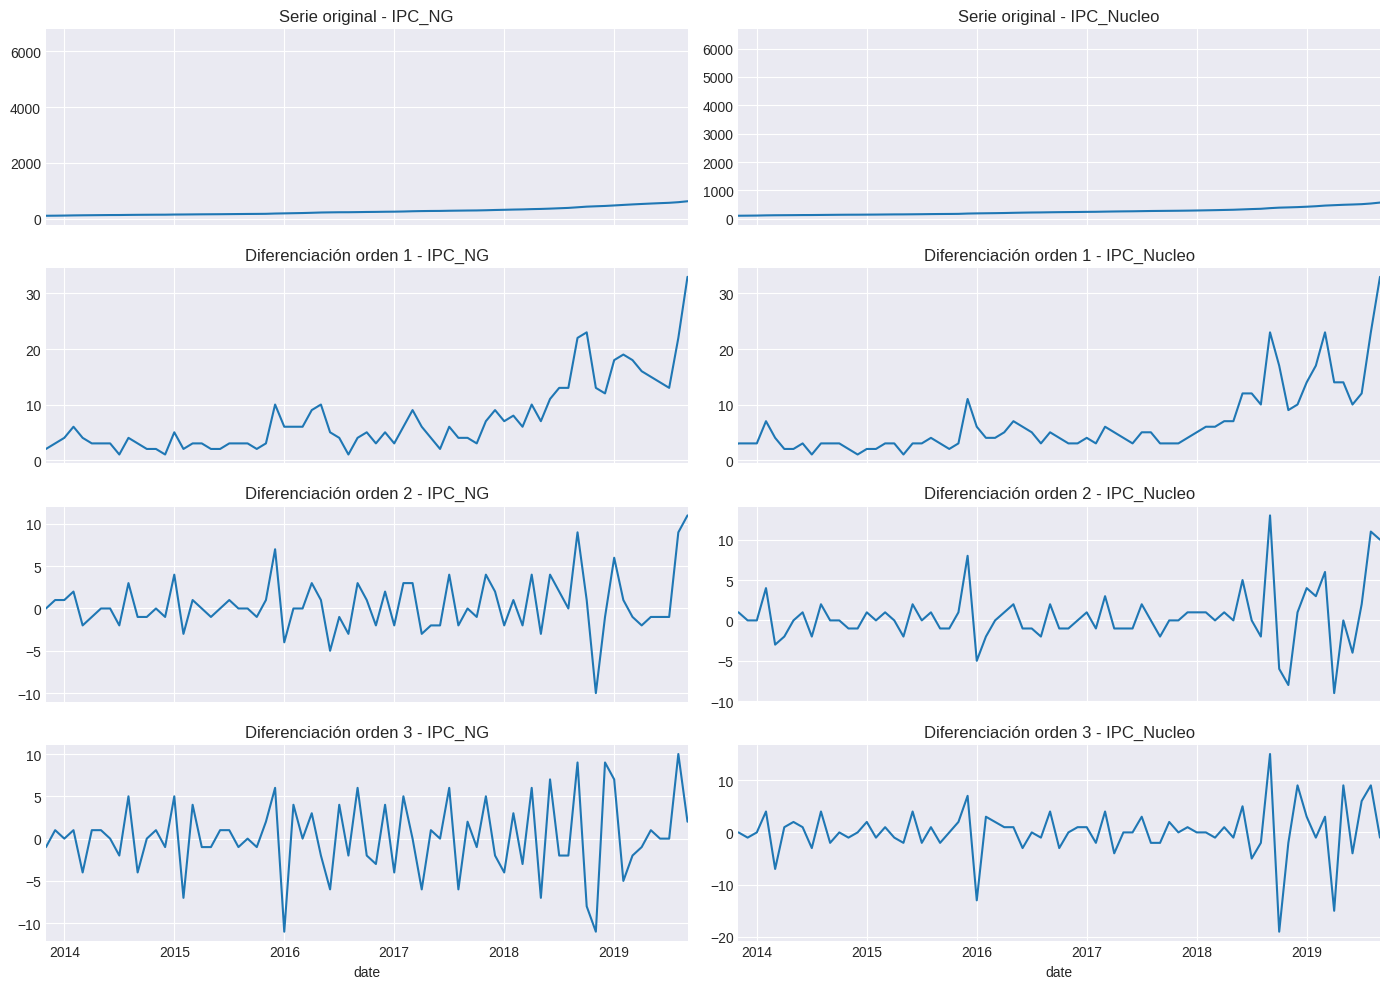

In [ ]:
# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 10), sharex=True)

# Gráfico IPC_NG
datos['IPC_NG'].plot(ax=axs[0, 0], title='Serie original - IPC_NG')
datos_diff_1['IPC_NG'].plot(ax=axs[1, 0], title='Diferenciación orden 1 - IPC_NG')
datos_diff_2['IPC_NG'].plot(ax=axs[2, 0], title='Diferenciación orden 2 - IPC_NG')
datos_diff_3['IPC_NG'].plot(ax=axs[3, 0], title='Diferenciación orden 3 - IPC_NG')

# Gráfico IPC_Nucleo
datos['IPC_Nucleo'].plot(ax=axs[0, 1], title='Serie original - IPC_Nucleo')
datos_diff_1['IPC_Nucleo'].plot(ax=axs[1, 1], title='Diferenciación orden 1 - IPC_Nucleo')
datos_diff_2['IPC_Nucleo'].plot(ax=axs[2, 1], title='Diferenciación orden 2 - IPC_Nucleo')
datos_diff_3['IPC_Nucleo'].plot(ax=axs[3, 1], title='Diferenciación orden 3 - IPC_Nucleo')

plt.tight_layout()
plt.show()

En base a los resultados de los test, la selección más adecuada para el parámetro ARIMA  d es 2 para la serie de IPC Nivel General y de 3 para la serie de IPC Núcleo

##2- Análisis de Autocorrelación

El gráfico de la función de autocorrelación ( Autocorrelation Function ACF) y la función de autocorrelación parcial (Partial Autocorrelation Function (PACF)) de la serie temporal proporciona información útil sobre los posibles valores adecuados de  p
  y  q
 . La ACF ayuda a identificar el valor de  q
  (retardos en la parte de media móvil), mientras que la PACF ayuda a identificar el valor de  p
  (retardos en la parte autorregresiva).

<font color='pink'> Si el análisis de estacionariedad indica que es necesario diferenciar las series, los análisis posteriores deben realizarse utilizando la serie diferenciada, ya que esta es la forma en que el modelo ARIMA interpreta la serie.

### Función de Autocorrelación (ACF)


La ACF mide la relación lineal entre las observaciones de una serie de datos Y distanciados en un lapso de tiempo *k* . A este lapso de tiempo *k* de lo conoce como *retardos, retrasos o lags *

 En el contexto de la modelización ARIMA, una caída brusca de la ACF después de unos pocos retardos indica que los datos tienen un orden autorregresivo finito. El retardo en el que cae la ACF proporciona una estimación del valor de  q.

 Si el ACF muestra un patrón sinusoidal o sinusoidal amortiguado, sugiere la presencia de estacionalidad y requiere la consideración de órdenes estacionales además de órdenes no estacionales.

### Función de autocorrelación parcial (PACF)


La PACF es una medida asociada a la ACF. Se puede describir como la estimación de la ACF para el mismo retardo *k*, con la eliminación del efecto producido por las autocorrelaciones para retardos menores a *k*, las cuales están presentes en la estimación de la ACF.

En el contexto de la modelización ARIMA, si la PACF se corta bruscamente después de un determinado retardo, mientras que los valores restantes están dentro del intervalo de confianza, sugiere un modelo AR de ese orden. El desfase en el que se corta el PACF da una idea del valor de  p.

La diferencia entre la ACF y la PACF puede resumirse en que mientras la ACF nos muestra para un retardo *k* tanto la relación entre las observaciones con una diferencia de *k* rezagos de tiempo, como la relación para rezagos menores. La PACF sólo nos muestra la relación para la diferencia estricta en *k* rezagos de tiempo, descartando la influencia de los rezagos intermedios.

**Algunas reglas generales son:**
Utilizar un orden del término AR p igual al numero de *lags* que cruzan el límite de significancia en el gráfico PACF.

Utilizar un orden del término MA q igual al numero de *lags* que cruzan el límite de significancia en el gráfico ACF.

Si el ACF corta en el lag q y el PACF corta en el lag p, se recomienda empezar con un modelo ARIMA(p, d, q).

Si sólo el PACF decae después del lag p, se recomienda empezar con un modelo AR(p).

Si sólo el ACF decae después del lag q, se recomienda empezar con un modelo MA(q).

Estas pautas proporcionan un punto de partida útil al seleccionar los órdenes de un modelo ARIMA y pueden ser ajustadas según las características específicas de los datos en cuestión.

                       SERIE IPC NIVEL GENERAL                       
   


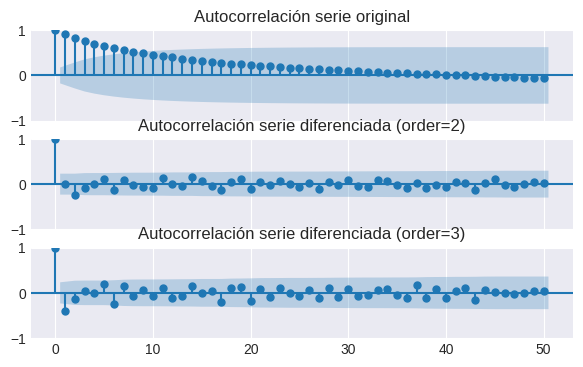

In [ ]:
# Grafico de autocorrelación para la serie original y la serie diferenciada de orden 2 y 3 de la Serie de IPC NG
# =========================================================================================================

# Definir título centrado y de color amarillo
title = 'SERIE IPC NIVEL GENERAL'
title_formatted = f"\033[33m{' ' * ((70 - len(title)) // 2)}\033[2m{title}\033[0m{' ' * ((70 - len(title)) // 2)}\033[0m"


print(title_formatted)
print ('   ')


fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(datos.IPC_NG, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_2.IPC_NG, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=2)');
plot_acf(datos_diff_3.IPC_NG, ax=axs[2], lags=50, alpha=0.05)
axs[2].set_title('Autocorrelación serie diferenciada (order=3)');

                           SERIE IPC NUCLEO                           
   


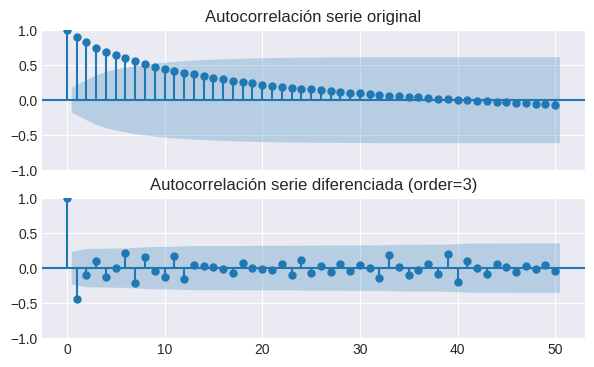

In [ ]:
# Grafico de autocorrelación para la serie original y la serie diferenciada de orden 3 de la Serie de IPC NUCLEO
# =========================================================================================================

# Definir título centrado y de color amarillo
title = 'SERIE IPC NUCLEO'
title_formatted = f"\033[33m{' ' * ((70 - len(title)) // 2)}\033[2m{title}\033[0m{' ' * ((70 - len(title)) // 2)}\033[0m"


print(title_formatted)
print ('   ')


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(datos.IPC_Nucleo, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_3.IPC_Nucleo, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=3)');


                       SERIE IPC NIVEL GENERAL                       
   


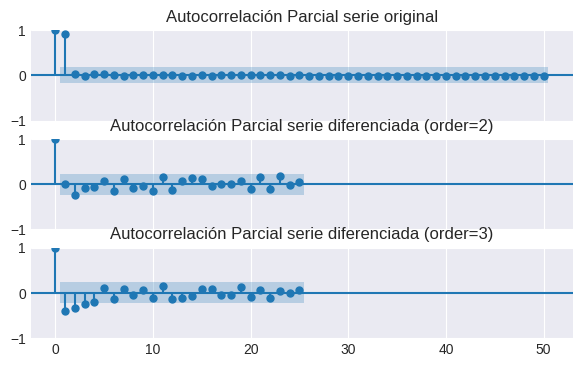

In [ ]:
# Grafico de autocorrelación Parcial para la serie original y la serie diferenciada de orden 2 y 3 de la Serie de IPC NG
# =========================================================================================================

# Definir título centrado y de color amarillo
title = 'SERIE IPC NIVEL GENERAL'
title_formatted = f"\033[33m{' ' * ((70 - len(title)) // 2)}\033[2m{title}\033[0m{' ' * ((70 - len(title)) // 2)}\033[0m"


print(title_formatted)
print ('   ')


fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 4), sharex=True)
plot_pacf(datos.IPC_NG, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación Parcial serie original')
plot_pacf(datos_diff_2.IPC_NG, ax=axs[1], lags=25, alpha=0.05)
axs[1].set_title('Autocorrelación Parcial serie diferenciada (order=2)');
plot_pacf(datos_diff_3.IPC_NG, ax=axs[2], lags=25, alpha=0.05)
axs[2].set_title('Autocorrelación Parcial serie diferenciada (order=3)');

                           SERIE IPC NUCLEO                           
   


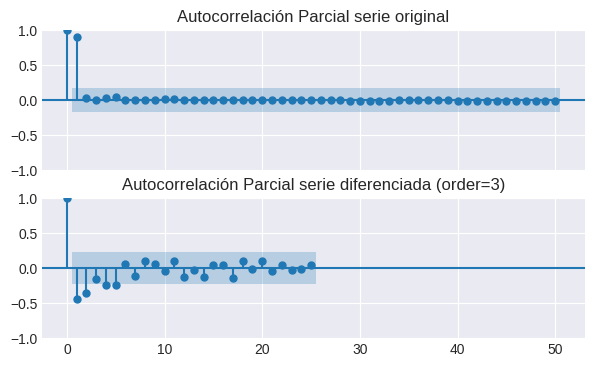

In [ ]:
# Grafico de autocorrelación Parcial para la serie original y la serie diferenciada de orden 3 de la Serie de IPC NUCLEO
# =========================================================================================================

# Definir título centrado y de color amarillo
title = 'SERIE IPC NUCLEO'
title_formatted = f"\033[33m{' ' * ((70 - len(title)) // 2)}\033[2m{title}\033[0m{' ' * ((70 - len(title)) // 2)}\033[0m"


print(title_formatted)
print ('   ')


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_pacf(datos.IPC_Nucleo, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación Parcial serie original')
plot_pacf(datos_diff_3.IPC_Nucleo, ax=axs[1], lags=25, alpha=0.05)
axs[1].set_title('Autocorrelación Parcial serie diferenciada (order=3)');

Acorde a la función de autocorrelación, el valor óptimo para el parámetro  p
  es 0. Sin embargo, se va a asignar un valor de 1 para proporcionar un componente autorregresivo al modelo. En cuanto al componente  q
 , la función de autocorrelación parcial sugiere un valor de 1.

##3- Descomposición de series temporales



La descomposición de series temporales consiste en descomponer la serie temporal original en sus componentes fundamentales. Podemos descomponer nuestra serie para comprender la influencia de cada componente y usar eso para guiar nuestra preparación de datos, selección de modelos y ajuste de modelos.


Podemos pensar en nuestra serie temporal como compuesta por una combinación de nivel, tendencia, estacionalidad y ruido.

- nivel: El valor promedio de la serie
- tendencia: El valor creciente o decreciente en la serie
- estacionalidad: El ciclo de corto plazo que se repite en la serie
- ruido: La variación aleatoria en la serie, denominada residual por la función de descomposición_estacional

Una estaciòn es un período de tiempo fijo que contiene la repetición completa del patrón de su serie temporal. Preste mucha atención, sus datos pueden repetirse todos los días, pero si los fines de semana se ven diferentes a los días de la semana, entonces su temporada es una semana, no un día.


La descomposición estacional en `statsmodels` solo requiere que indiquemos si el modelo es aditivo o multiplicativo.

Esta es una descomposición ingenua, utilizada principalmente para la descripción de datos.

El modelo aditivo es Y[t] = T[t] + S[t] + e[t]

El modelo multiplicativo es Y[t] = T[t] * S[t] * e[t]

Los resultados se obtienen estimando primero la tendencia aplicando un filtro de convolución a los datos. Luego, la tendencia se elimina de la serie y el promedio de esta serie sin tendencia para cada período es el componente estacional devuelto.


### Additive vs. Multiplicative

En una serie de tiempo multiplicativa, los componentes descompuestos se multiplican para formar la serie de tiempo. En una serie multiplicativa hay tendencia creciente, aumenta la amplitud de la actividad estacional y todo se vuelve más exagerado. La tendencia multiplicativa se parece más a una curva exponencial y la estacionalidad multiplicativa tiene ondas que crecen en amplitud a lo largo del tiempo.

En un modelo aditivo asumimos que los componentes de la serie de tiempo tienen un efecto aditivo, que la amplitud del efecto estacional es aproximadamente la misma, que el tamaño de los residuos es mayormente constante.

Los datos del mundo real no siempre serán puramente aditivos o multiplicativos, puede haber secciones de cualquier tipo. Es importante probar varios parámetros y ver cuál se ajusta mejor a nuestros datos.

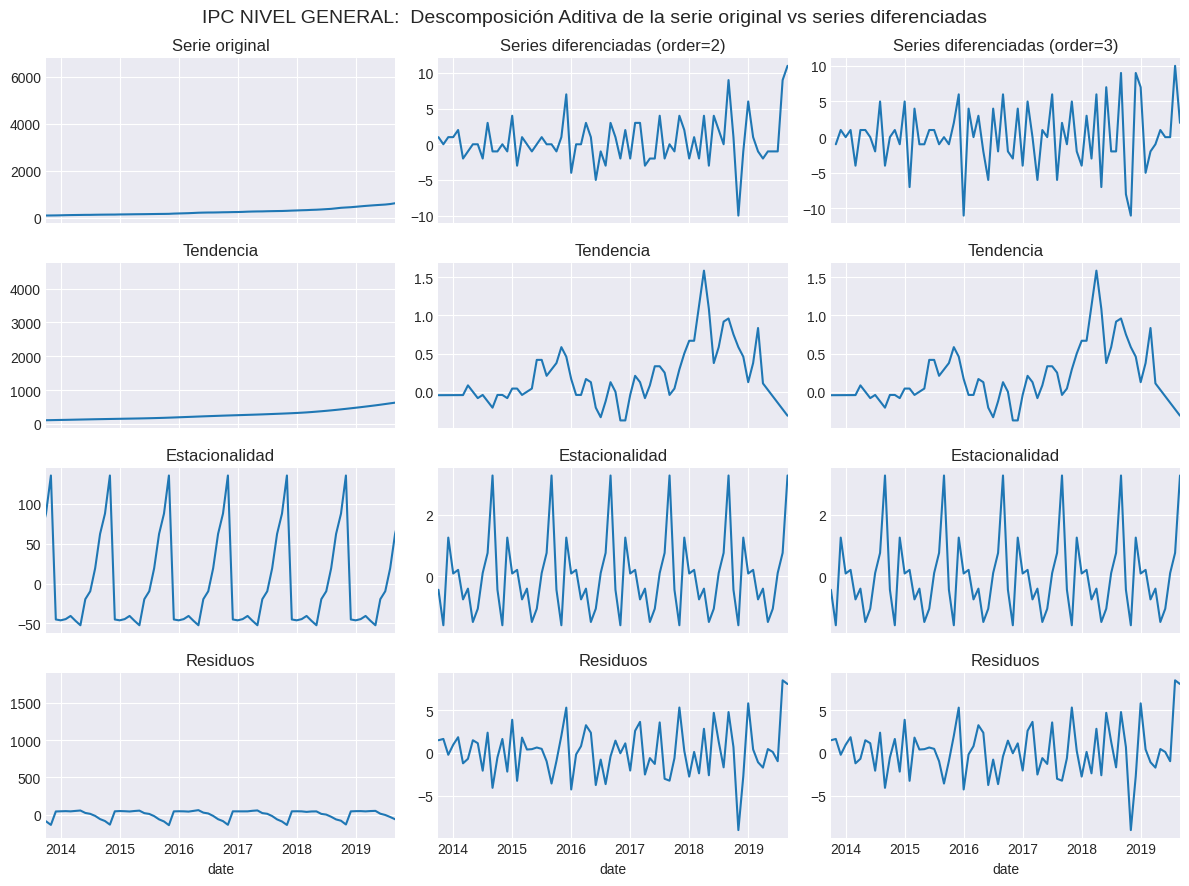

In [ ]:
# Descomposición Aditiva de la serie original y las series diferenciadas: IPC Nivel General
# ==============================================================================
res_decompose_NG = seasonal_decompose(datos.IPC_NG, model='additive', extrapolate_trend='freq')
res_descompose_diff_2_NG = seasonal_decompose(datos_diff_2.IPC_NG, model='additive', extrapolate_trend='freq')
res_descompose_diff_3_NG = seasonal_decompose(datos_diff_3.IPC_NG, model='additive', extrapolate_trend='freq')


fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 9), sharex=True)
res_decompose_NG.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original')
res_decompose_NG.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia')
res_decompose_NG.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad')
res_decompose_NG.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos')

res_descompose_diff_2_NG.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=2)')
res_descompose_diff_2_NG.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia')
res_descompose_diff_2_NG.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad')
res_descompose_diff_2_NG.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos')

res_descompose_diff_3_NG.observed.plot(ax=axs[0, 2])
axs[0, 2].set_title('Series diferenciadas (order=3)')
res_descompose_diff_2_NG.trend.plot(ax=axs[1, 2])
axs[1, 2].set_title('Tendencia')
res_descompose_diff_2_NG.seasonal.plot(ax=axs[2, 2])
axs[2, 2].set_title('Estacionalidad')
res_descompose_diff_2_NG.resid.plot(ax=axs[3, 2])
axs[3, 2].set_title('Residuos')



fig.suptitle('IPC NIVEL GENERAL:  Descomposición Aditiva de la serie original vs series diferenciadas', fontsize=14)
fig.tight_layout();

El patrón recurrente cada 12 meses sugiere una estacionalidad anual, probablemente influenciada por factores vacacionales.

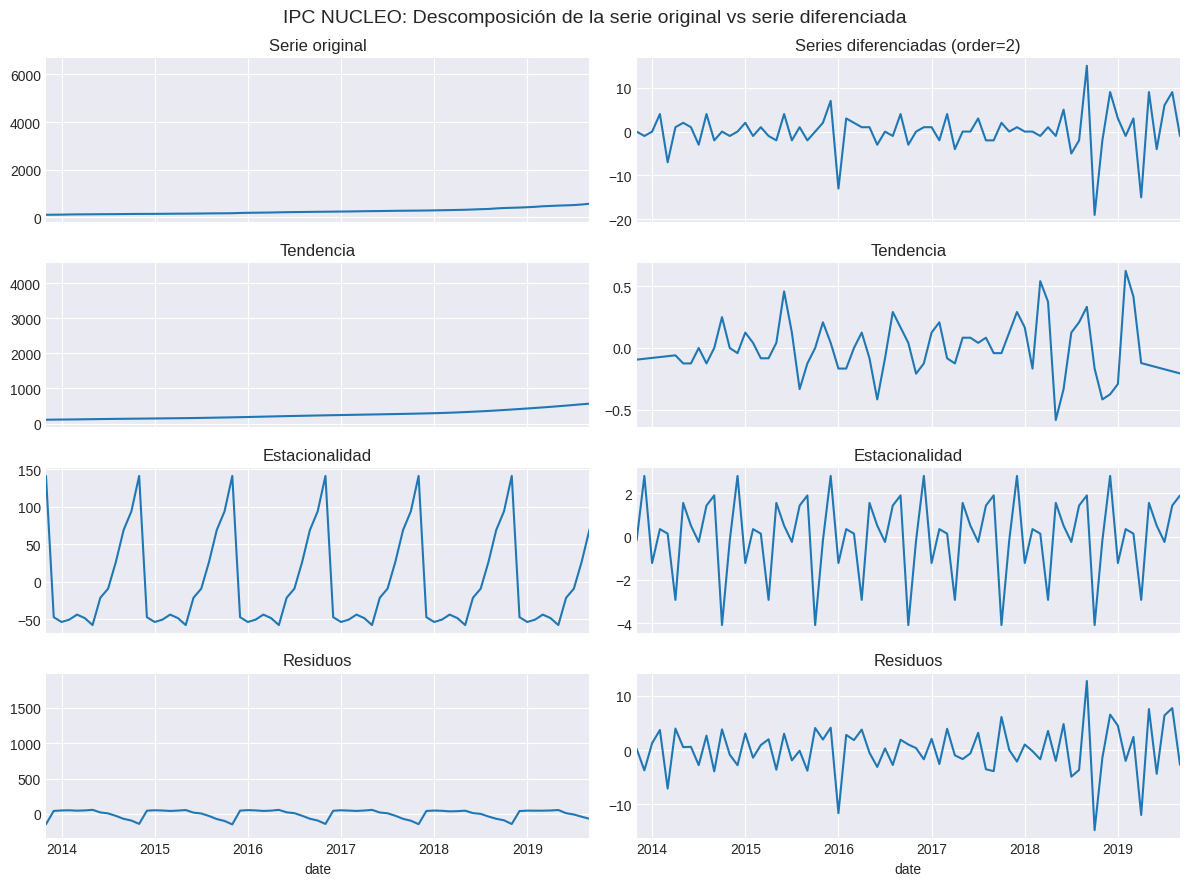

In [ ]:
# Descomposición de la serie original y la series diferenciada de orden 3: IPC Núcleo
# ==============================================================================
res_decompose_Nucleo = seasonal_decompose(datos.IPC_Nucleo, model='additive', extrapolate_trend='freq')
res_descompose_diff_3_Nucleo = seasonal_decompose(datos_diff_3.IPC_Nucleo, model='additive', extrapolate_trend='freq')


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 9), sharex=True)
res_decompose_Nucleo.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original')
res_decompose_Nucleo.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia')
res_decompose_Nucleo.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad')
res_decompose_Nucleo.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos')

res_descompose_diff_3_Nucleo.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=2)')
res_descompose_diff_3_Nucleo.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia')
res_descompose_diff_3_Nucleo.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad')
res_descompose_diff_3_Nucleo.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos')



fig.suptitle('IPC NUCLEO: Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

## Conclusiones

Basandose en los resultados del análisis exploratorio, utilizar una combinación de diferenciación de segundo orden y diferenciación estacional puede ser el enfoque más apropiado.

La diferenciación de segundo orden es efectiva para capturar las transiciones entre observaciones y resaltar las fluctuaciones a corto plazo. Al mismo tiempo, la diferenciación estacional, que abarca un período de 12 meses y representa el cambio de un año a otro, captura de manera efectiva los patrones cíclicos inherentes en los datos. Este enfoque nos permite lograr la estacionariedad necesaria para el proceso de modelado ARIMA subsiguiente.

In [ ]:
# Diferenciaciación de orden 3 combinada con diferenciación estacional

datos_diff_3_12_NG=datos_train.IPC_NG.diff().diff().diff().diff(12).dropna()
warnings.filterwarnings("ignore")

print('IPC Nivel General Difereciación orden 3')
adfuller_result= adfuller(datos_diff_3_12_NG)
print(f'ADF Statistic:{adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_3_12_NG)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

IPC Nivel General Difereciación orden 3
ADF Statistic:-2.7447714002415395, p-value: 0.06660607542074883
KPSS Statistic: 0.22966563346289345, p-value: 0.1


con el 5% se acepta ADF (la serie es no estacionaria), se acepta KPSS (la serie es estacionaria). Con el 10% se rechaza ADF



In [ ]:
# Diferenciaciación de orden 3 combinada con diferenciación estacional

datos_diff_3_12_Nucleo=datos_train.IPC_Nucleo.diff().diff().diff().diff(12).dropna()
warnings.filterwarnings("ignore")

print('IPC Nucleo Difereciación orden 3')
adfuller_result_nucleo= adfuller(datos_diff_3_12_Nucleo)
print(f'ADF Statistic:{adfuller_result_nucleo[0]}, p-value: {adfuller_result_nucleo[1]}')
kpss_result_nucleo = kpss(datos_diff_3_12_Nucleo)
print(f'KPSS Statistic: {kpss_result_nucleo[0]}, p-value: {kpss_result_nucleo[1]}')
warnings.filterwarnings("default")

IPC Nucleo Difereciación orden 3
ADF Statistic:-2.3048803553193595, p-value: 0.17039879076789233
KPSS Statistic: 0.2183803948903852, p-value: 0.1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


con el 5% se acepta ADF (serie no es estacionaria) y se acepta KPSS (la serie es estacionaria)

El análisis exploratorio de datos es un proceso iterativo en el que los conocimientos adquiridos pueden cambiar a medida que avanza el proceso. Es importante recordar que todos los gráficos anteriores solo proporcionan orientación inicial y que los valores óptimos de  p
 ,  q
 , y  d
  deben seleccionarse en base a una combinación de estos gráficos, criterios estadísticos como AIC y BIC, y una validación de series temporales como el backtesting.

# Modelo ARIMA


cómo entrenar un modelo ARIMA-SARIMAX y PREDECIR valores futuros utilizando cada una de las tres librerías.

##1 - Statmodel

En statsmodels, se diferencia entre el proceso de definir un modelo y entrenarlo.

El proceso comienza con la definición del modelo, que incluye los parámetros configurables y el conjunto de datos de entrenamiento. Cuando se invoca al método de ajuste (fit). En lugar de modificar el objeto modelo, como es típico en las librerías de Python, statsmodels crea un nuevo objeto SARIMAXResults. Este objeto no solo encapsula detalles esenciales como los residuos y los parámetros aprendidos, sino que también proporciona las herramientas necesarias para generar predicciones.

In [ ]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos_train.IPC_NG, order = (2, 3, 1), seasonal_order = (2, 3, 1, 12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             IPC_NG   No. Observations:                   74
Model:             SARIMAX(2, 3, 1)x(2, 3, 1, 12)   Log Likelihood                -125.231
Date:                            Fri, 01 Mar 2024   AIC                            264.462
Time:                                    19:35:15   BIC                            275.349
Sample:                                08-01-2013   HQIC                           268.220
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2827      0.364     -0.777      0.437      -0.996       0.430
ar.L2         -0.3235      0.214     -1.511      0.131      -0.743       0.096
ma.L1         -0.9909      5.499     -0.180      0.857     -11.768       9.787
ar.S.L12      -1.7918     10.541     -0.170      0.865     -22.452      18.868
ar.S.L24      -0.9177     10.760     -0.085      0.932     -22.006      20.171
ma.S.L12       0.9808    535.427      0.002      0.999   -1048.438    1050.399
sigma2         9.3179   4826.741      0.002      0.998   -9450.921    9469.557
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.43   Prob(JB):                         0.48
Heteroskedasticity (H):               1.49   Skew:                            -0.47
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El resumen del modelo muestra mucha información sobre el proceso de ajuste:

Estadísticas de Ajuste del Modelo: Esta parte incluye varias estadísticas que ayudan a evaluar qué tan bien el modelo se ajusta a los datos observados:

Log-Likelihood (Logaritmo de la Verosimilitud): Una medida de qué tan bien el modelo explica los datos observados, donde valores más negativos indican un ajuste deficiente a los datos y valores más cercanos a cero indican un mejor ajuste.

AIC (Criterio de Información de Akaike): Una métrica de bondad de ajuste que equilibra el ajuste del modelo con su complejidad. Cuanto menor el valor de AIC mejor es el modelo.

BIC (Criterio de Información Bayesiano): Similar al AIC, pero penaliza más la complejidad del modelo. Al igual que con el AIC, valores más bajos de BIC indican un mejor ajuste.

HQIC (Criterio de Información de Hannan-Quinn): Otro criterio de selección de modelo, similar al AIC y al BIC.

Coeficientes: Esta tabla lista los coeficientes estimados para los parámetros del modelo. Incluye tanto los parámetros autoregresivos (AR) como los parámetros de media móvil (MA), así como cualquier variable exógena si se incluyen en el modelo. También incluye los errores estándar asociados con los coeficientes estimados para indicar la incertidumbre de dichas estimaciones, sus p-values, que se utilizan para evaluar la significancia de cada coeficiente, y el intervalo de confianza del 95%.

Diagnósticos del modelo: Esta sección proporciona información sobre los residuos. Las diferencias entre los valores observados (valores de entrenamiento) y los valores predichos por el modelo.

Prueba Ljung-Box: Una prueba de autocorrelación en los residuos.

Prueba de Jarque-Bera: Una prueba de normalidad de los residuos.

Asimetría y curtosis: Medidas de la forma de la distribución de los residuos.

In [ ]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test.IPC_NG)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2019-10-01    655.113599
2019-11-01    673.336615
2019-12-01    684.050009
2020-01-01    707.409439
Freq: MS, Name: predicciones_statsmodels, dtype: float64

## 2- Skforecast

La clase skforecast.Sarimax envuelve el modelo statsmodels.SARIMAX y lo adapta a la API de scikit-learn.

In [ ]:
# Modelo SARIMAX con skforecast.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = Sarimax(order=(0, 2, 0), seasonal_order=(0, 2, 0, 12))
modelo.fit(y=datos_train.IPC_NG)
modelo.summary()
warnings.filterwarnings("default")

/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduc

In [ ]:
# Predictión
# ==============================================================================
predicciones_skforecast = modelo.predict(steps=len(datos_test.IPC_NG))
display(predicciones_skforecast.head(4))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pred
2019-10-01,661.0
2019-11-01,673.0
2019-12-01,681.0
2020-01-01,703.0


## 3 - pdmarima

In [ ]:
# Modelo SARIMAX con pdmarima.Sarimax
# ==============================================================================
modelo = ARIMA(order=(0, 2, 0), seasonal_order=(0, 2, 0, 12))
modelo.fit(y=datos_train.IPC_NG)
modelo.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/usr/local/lib/python3.10/dist-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   74
Model:             SARIMAX(0, 2, 0)x(0, 2, 0, 12)   Log Likelihood                -162.653
Date:                            Fri, 01 Mar 2024   AIC                            329.307
Time:                                    19:35:16   BIC                            333.049
Sample:                                08-01-2013   HQIC                           330.721
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1042      1.091     -0.095      0.924      -2.243       2.035
sigma2        51.3850     11.554      4.447      0.000      28.740      74.030
===================================================================================
Ljung-Box (L1) (Q):                   1.63   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.20   Prob(JB):                         0.46
Heteroskedasticity (H):               1.70   Skew:                            -0.43
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#predicciones
predicciones_pdmarima=modelo.predict(len(datos_test))
predicciones_pdmarima.name='predicciones pdmarima'
display(predicciones_pdmarima.head(4))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2019-10-01    660.895833
2019-11-01    672.687500
2019-12-01    680.375000
2020-01-01    701.958333
Freq: MS, Name: predicciones pdmarima, dtype: float64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDe

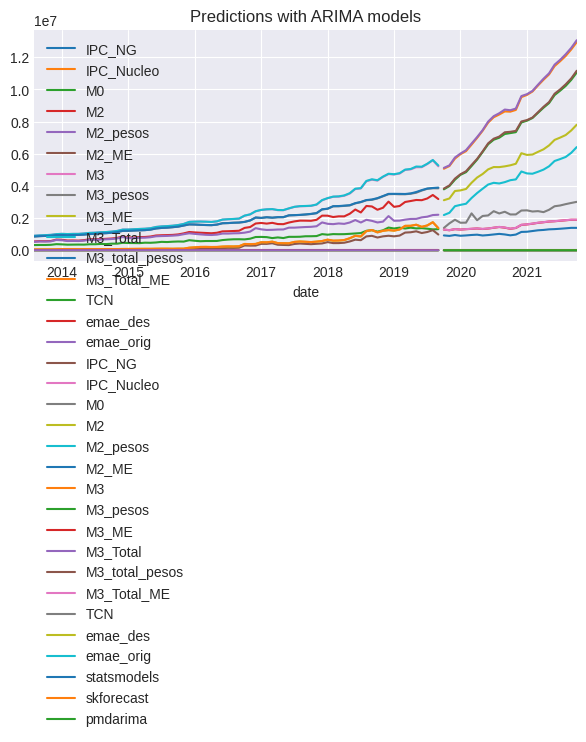

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones_statsmodels.plot(ax=ax, label='statsmodels')
predicciones_skforecast.columns = ['skforecast']
predicciones_skforecast.plot(ax=ax, label='skforecast')
predicciones_pdmarima.plot(ax=ax, label='pmdarima')
ax.set_title('Predictions with ARIMA models')
ax.legend();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# SARIMAX

In [ ]:
correlation_matrix = datos.corr()

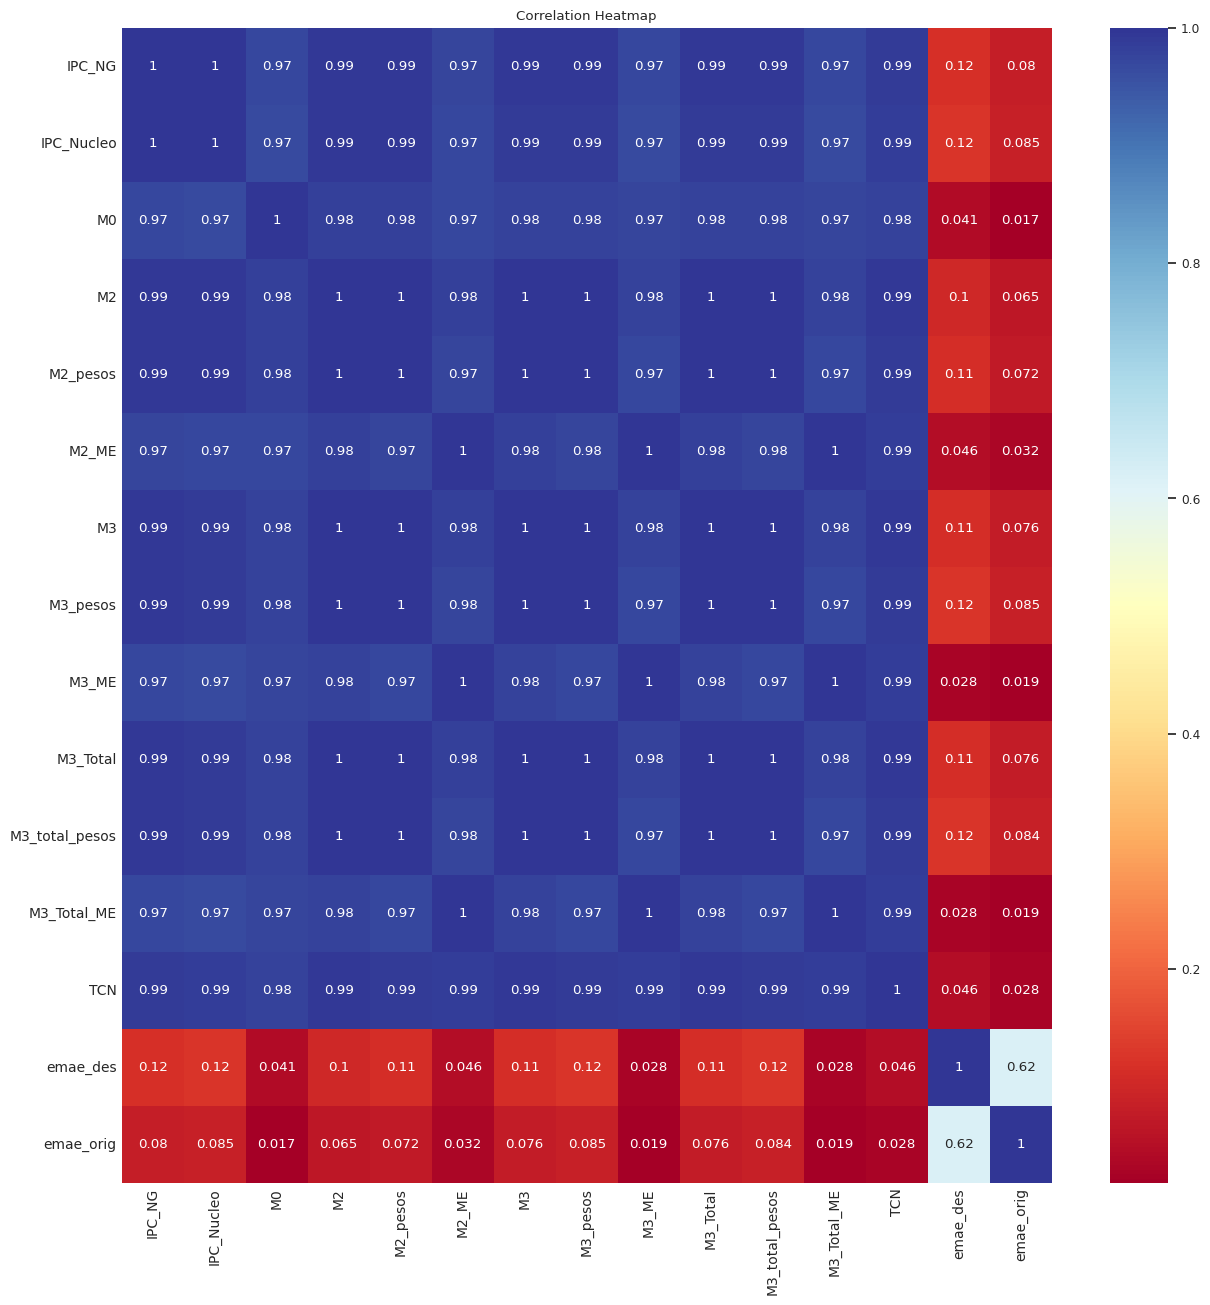

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(font_scale=0.8)
#plt.show()

ax =  sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu')
plt.title('Correlation Heatmap')
plt.show()

## Train Forecaster

In [ ]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 15
             )

forecaster.fit(
    y    = datos_train['IPC_NG'],
    exog = datos_train[['M0', 'M2', 'M3', 'M3_Total', 'TCN']]
)

forecaster

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['M0', 'M2', 'M3', 'M3_Total', 'TCN'] 
Training range: [Timestamp('2013-08-01 00:00:00'), Timestamp('2019-09-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 20

**ForecasterAutoreg**: Es el tipo de objeto que has creado. En este caso, es un objeto de la clase ForecasterAutoreg.

**Regressor**: Es el modelo utilizado como regresor en el forecaster. En este caso, es un RandomForestRegressor con el parámetro random_state establecido en 123.

**Lags**: Son los retardos utilizados en el modelo autoregresivo. Aquí, los lags son [1, 2, 3, ..., 15], lo que significa que se están utilizando 15 retardos para predecir la variable objetivo.

**Transformer for y y Transformer for exog **: Son los transformadores utilizados para transformar las variables objetivo (y) y exógenas (exog) antes de ajustar el modelo. En este caso, no se ha aplicado ninguna transformación (None).

**Window size**: Es el tamaño de la ventana utilizado en el ajuste del modelo. En este caso, el tamaño de la ventana es 15, lo que significa que se están utilizando 15 observaciones pasadas para predecir la siguiente observación.

**Weight function included**: Indica si se ha incluido una función de peso en el modelo. En este caso, no se ha incluido (False).

**Differentiation order**: Es el orden de diferenciación aplicado a la serie temporal. En este caso, no se ha aplicado ninguna diferenciación (None).

**Exogenous included **: Indica si se han incluido variables exógenas en el modelo. En este caso, sí se han incluido (True).

**Type of exogenous variable**: Es el tipo de datos de las variables exógenas. En este caso, son objetos de tipo pandas.core.frame.DataFrame.

**Exogenous variables names**: Son los nombres de las variables exógenas utilizadas en el modelo. En tu caso, las variables exógenas son ['M0', 'M2', 'M3', 'M3_Total', 'TCN'].

**Training range**: Es el rango de fechas utilizado para entrenar el modelo. En este caso, las fechas van desde el 1 de agosto de 2013 hasta el 1 de septiembre de 2019.

**Training index type y Training index frequency**: Son el tipo y la frecuencia del índice de tiempo utilizado en los datos de entrenamiento. En este caso, el tipo es DatetimeIndex y la frecuencia es MS (mes a mes).

**Regressor parameters**: Son los parámetros utilizados en el regresor (en este caso, RandomForestRegressor). Estos son los mismos parámetros que proporcionaste al crear el objeto ForecasterAutoreg.

**fit_kwargs**: Son los argumentos adicionales pasados al método fit(). En este caso, no se han proporcionado argumentos adicionales ({}).

**Creation date y Last fit date**: Son las fechas de creación y ajuste del modelo.




## Prediction

Si el pronosticador ha sido entrenado utilizando variables exógenas, se deben proporcionar durante la fase de predicción.

In [ ]:
# Predict
# ==============================================================================
steps = 25 #usar longitud datos test
predictions = forecaster.predict(
                  steps = steps,
                  exog = datos_test[['M0', 'M2', 'M3', 'M3_Total', 'TCN']]
              )

predictions.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2019-10-01    593.86
2019-11-01    600.93
2019-12-01    601.23
Freq: MS, Name: pred, dtype: float64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


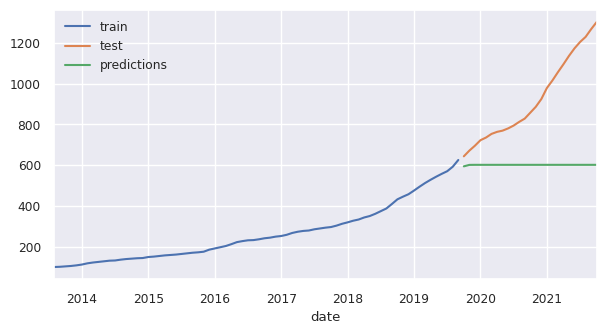

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3.5))
datos_train['IPC_NG'].plot(ax=ax, label='train')
datos_test['IPC_NG'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:

# Prediction error
error_mse = mean_squared_error(
                y_true = datos_test['IPC_NG'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 144401.950448


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



## Feature importances


Feature Importance, o importancia de características, es un concepto importante en el aprendizaje automático y se refiere a la evaluación de la contribución relativa de cada característica o variable predictora en un modelo de aprendizaje automático para realizar predicciones. Es decir, determina qué tan importante es cada característica para explicar o predecir la variable objetivo.

La importancia de características puede ser valiosa en varias situaciones:

Selección de características: Permite identificar qué características son las más relevantes para un modelo, lo que puede ayudar a reducir la dimensionalidad y mejorar la eficiencia del modelo.

Entendimiento del modelo: Proporciona información sobre cómo el modelo está tomando decisiones y qué características son más influyentes en esas decisiones, lo que puede ser útil para interpretar el modelo.

Detectar características irrelevantes: Si se encuentran características con importancia cercana a cero, es probable que sean irrelevantes para el modelo y puedan eliminarse para mejorar la simplicidad y la eficacia del modelo.

<span style="color: orange;">Seleccionen el mejor modelo de lo obtenido en GridSearch y determinen la importancia relativa de cada variable predictora.</span>

In [ ]:
feature_importance=forecaster.get_feature_importances()
feature_importance

,feature,importance
0,lag_1,0.037166
1,lag_2,0.038980
2,lag_3,0.078235
3,lag_4,0.027218
4,lag_5,0.041010
5,lag_6,0.024754
6,lag_7,0.075651
7,lag_8,0.052735
8,lag_9,0.053162
9,lag_10,0.054720


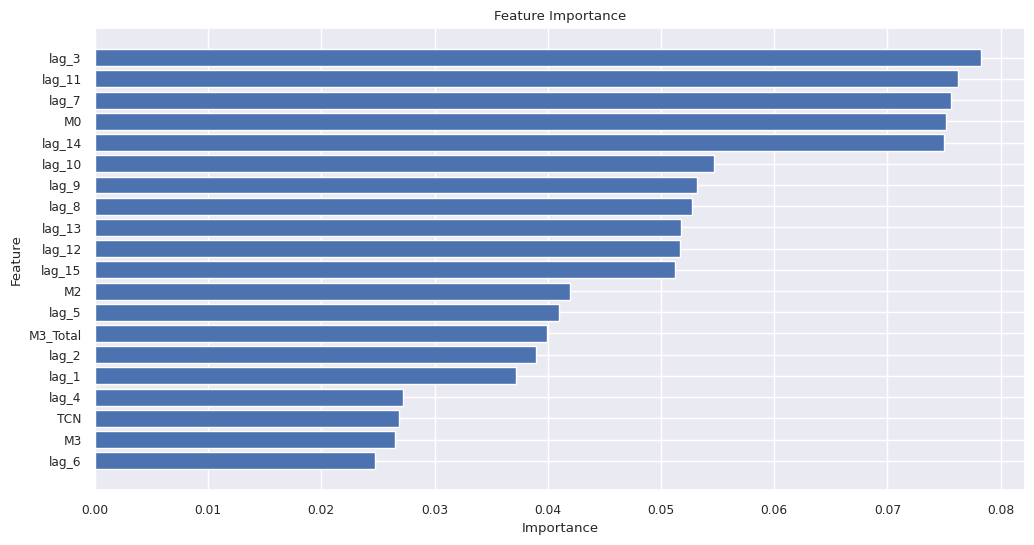

In [ ]:
# Ordenar el DataFrame por la columna 'importance' de forma descendente
feature_importance_sorted = feature_importance.sort_values(by='importance', ascending=True)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_sorted['feature'], feature_importance_sorted['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Bibliografía


Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. book  https://otexts.com/fpp3/

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov book  https://openforecast.org/adam/

Python for Finance: Mastering datos-Driven Finance book  https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055

Forecasting: theory and practice PDF  https://arxiv.org/pdf/2012.03854.pdf